# CIFAR Classification using Convolutional Nueral Networks

This notebook aims to illustrate how tensorflow 1.4 can be used to construct different models to perform CIFAR classification. The different models together with their results are presented here below.

**Please note that this notebook is still under construction and therefore something might not be fully clear or in fully functional form.**
<hr>

### Basic overview and setting up

There are a number of packages needed for this repository. These are listed in requirements.txt. However, some will be needed to run this notebook and these are imported here below. The _os_ and _datetime_ packages are needed to set the log filenames, _tensorflow_ to define the graphs and the repo package _pcyf_ where the functions are defined to import the models and any needed utility functions.

The log level is set to 2 to suppress build warnings when setting up the tensorflow graphs. 

Finally, some test constant variables such as the number of epochs and batch_size are also defined here.

In [1]:
# Import packages
import os
import datetime
import tensorflow as tf

from pycf import models as models
from pycf.data_providers import CIFAR10DataProvider
from pycf.utils import show_graph, display_image

# Set log level to suppress build warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Model variables to be kept constant throughout all the tests
NUM_EPOCH = 10
BATCH_SIZE = 100

The files downloaded from the CIFAR <a href="https://www.cs.toronto.edu/~kriz/cifar.html">website</a> are in pickle form. It would be easier if these were in _tfrecord_ format in order to be loaded into the graph. The format _tfrecord_ is a tensorflow defined binary format. It allows partial loading and hence not all images need to be in-memory for processing. The loading provider could be in a form of a FIFO where batches are loaded and processed sequentially. 

To convert the downloaded data to _tfrecord_, make sure the data files are in a _data/_ subfolder and then run `python -m pycf.data_prep` in the root directory.

Since the data is read through a _tfrecord_ the data provider can have its operations defined in the main graph. The class `CIFAR10DataProvider` in `pycf.data_providers` manages all the loading from the tfrecords. This designed function takes filenames from the `config/settings.py` file and defines a dataset to represent the data. the `CIFAR10DataProvider.next()` can be used to define the function for subsequent batches.

In the example below the batch of images is resized using the `tf.image.resize_images` function for better visualization. 

Since, everything is defined as tensors in the default graph, this graph needs to be run for the output to be produced. This is done using the `sess.run` after the variables have been initialized. An example image is shown. This is the image with index `sample_image_index` in the batch.

Possible labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


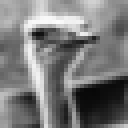

Associated label:   bird


In [8]:
# Sample image for context
sample_image_index = 1

with tf.Graph().as_default():
    
    # Define data provider
    train_data = CIFAR10DataProvider(batch_size=BATCH_SIZE, epochs=NUM_EPOCH, shape='3d')
    
    # Define next batch function from data provider
    next_example, next_labels = train_data.next()
    label_map = train_data.label_map()
    
    # Resize image for better visuals
    resized_images = tf.image.resize_images(next_example, [128, 128], tf.image.ResizeMethod.AREA)

    # Run tensorflow graph to produce numpy outputs from tensors
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        imgs, labels = sess.run([resized_images, next_labels])
    
    
print('Possible labels: ' + ', '.join(label_map))
display_image(imgs[sample_image_index])
print('Associated label:   ' + label_map[list(labels[sample_image_index]).index(1.0)])

The data provider which is defined in `pycf.data_providers` is a class which handles the `tf.data.Dataset` object. Once the data provider is created, the `.next()` function can be called to create a function to provide the next example and associated label in one-of-k encoding.

This next example and label can be next used to a graph found in `pycf.models`. This definition function returns some metrics ops such as error and accuracy and train ops such as summary and train step.

Here we are using a function called `show_graph` to show the graph in the notebook. This graph can also be seen on _Tensorboard_.

In [2]:
# Create Graph
modelA = tf.Graph()


with modelA.as_default():
    
    # Create dataset and function for next example
    train_data = CIFAR10DataProvider(batch_size=batch_size, epochs=num_epochs, shape='3d')
    next_example, next_label = train_data.next()
     
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        [imgs] = sess.run([next_example])
        display_flat_image(imgs[2])
        
    # Define model
    # metrics_ops, train_ops = models.fc6(next_example, next_label)
    #show_graph(tf.get_default_graph())

The model can now be trained to classify the different CIFAR images. Here we are training for `num_epochs * total_batches` steps. This essentailly means we are training for `num_epochs` loops through the training set. 

First we are defining the `train_writer` of the graph. This is used to write summaries to `Tensorboard`. We are then starting a session, and within the session we are:
    1. Initializing the variables
    2. Looping for the number of steps and running the graph. Since train_ops contains the train_step operation, this means 
        that the optimizer.minimize(error) is run. If this op is not run, the graph would not learn.
    3. Save the data to tensorboard on each loop and aggregate the error in variables.
    4. Print the error every 400 batches ie every epoch.

In [4]:


with modelA.as_default():
    
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    train_writer = tf.summary.FileWriter(os.path.join('tf-log', timestamp, 'train'), graph=tf.get_default_graph())
    
    with tf.Session() as sess:
    
        sess.run(tf.global_variables_initializer())
        
        running_err = 0
        running_acc = 0
        train_step = 0
        
        while train_step < num_epochs*total_batches:
            train_info, metrics = sess.run([train_ops, metrics_ops])
            
            train_writer.add_summary(train_info['summary'], train_step)
            running_err += metrics['error']
            running_acc += metrics['accuracy']
            
            if (train_step%total_batches==0) and (train_step!=0):
                print('Batch {0:02}\t| Average Error = {1:02.2f}\t| Average Accuracy = {2:.4f}'
                      .format(train_step, running_err/total_batches, running_acc/total_batches))
               
                running_err = 0
                running_acc = 0
            train_step +=1


Batch 400	| Average Error = 2.33	| Average Accuracy = 0.1136
Batch 800	| Average Error = 2.22	| Average Accuracy = 0.1316
Batch 1200	| Average Error = 2.15	| Average Accuracy = 0.1476
Batch 1600	| Average Error = 2.08	| Average Accuracy = 0.1633
Batch 2000	| Average Error = 2.04	| Average Accuracy = 0.1776
Batch 2400	| Average Error = 1.99	| Average Accuracy = 0.1911
Batch 2800	| Average Error = 1.95	| Average Accuracy = 0.2026


KeyboardInterrupt: 